# Inference and Validation

After having created a network, it has to be used for *making predictions* (named *inference*). Generally, neural networks perform very good on the training dataset, but perform poorly on the testing set. This is called **overfitting**. For measuring the overfitting, we use an unseen data called **validation set**. To *avoid overfitting* **regularization methods** are used, such as **dropout** while monitoring the validation performance during training.  
Generally, the 10-20% of the dataset is taken away for validation and testing purposes, and the other part is for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
# After the first download, we put @download=False@
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('.\\F_MNIST_data\\', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('.\\F_MNIST_data\\', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

RuntimeError: Dataset not found. You can use download=True to download it

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # We have to put here all the functions which address the
        # purposes of the class
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.shape[0],-1)
        # The activaction functions are found also in the module
        # torch.nn.functional
        # Generally, to call functions which are of the same class,
        # we have to call @self@
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Log of the probabilities to have a number which is not between 0 and 1,
        # but on the non positive axis of Real values
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

The goal of the validation is to measure the model's *performances on images (samples) which weren't seen by the model during training*.  
The measures to compute the performances can be:
- accuracy (generally used)
- precision
- recall
- top-5 error rate (fraction of test images for which the correct label is amongst the top 5 most likely labels)

We will use the accuracy.  
Now, we do a forward pass on a batch of the test set.

In [3]:
model = Classifier()
# We have to use the Negative Log Likelyhood Loss, because we have made the log 
# of the probabilities on the last layer, so we obtain a negative number
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.003)

images, labels = next(iter(trainloader))
# The images are already flattened in the forward method,
# so, we don't have to flatten them anymore
logps = model(images)

# we see that all the numbers are non positive
#print("Logarithms of the probabilities: ", logps)
print("Test over the sign: let's see if there are positive elements. Number of positive elems: ", torch.sum(logps>0))
# Compute the probabilities, using the exponential function
ps = torch.exp(logps)
#print("Output vector shape: ", ps.shape)
# Let's see if the probabilities over the classses sum up to 1
# We see the mean of the sum of probabilities over all the samples in a batch
print(f"The probabilities over the classes sum up to near 1? It is equal to {torch.sum(ps)/images.shape[0]}")

Test over the sign: let's see if there are positive elements. Number of positive elems:  tensor(0)
The probabilities over the classes sum up to near 1? It is equal to 1.0


Togheter with the vector of probabilities we can get also the k most probable classes thanks to the method `ps.topk`. It returns the k highest values togheter with the indices in the vector of probabilities (which corresponds to the class).  
Since we want the most likely class, we can use `ps.topk(1)`.  

The highest value between the probabilities in the vector of probabilities for the 6-sample is equal to tensor([0.1100], grad_fn=<SelectBackward>) and the class is tensor([8])


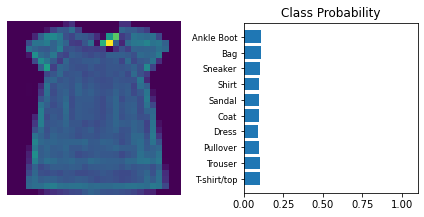

In [4]:
import random as rd
import helper as hp
top_p, top_class = ps.topk(1, dim=1)
# Returns the top k elements along a given dimension
# In our case we want the most probable case in the dimension 1 = we are passing the columns dimension
# so the probabilities between all the classes

# For each batch we have a probability
# we have that top_p and top_class have dimension (64,1)
# It is right because we have made the predictions of only a test batch (which is made of 64 images by construption)
k=rd.randrange(images.shape[0]-1)
top_p_k = top_p[k]
top_class_k = top_class[k]
print(f"The highest value between the probabilities in the vector of probabilities for the {k}-sample is equal to {top_p_k} and the class is {top_class_k}")
# We can visualize the vector of probabilities, too
hp.view_classify(images[k], ps[k], version="Fashion")


Now, we check if the predicted classes match the labels. This is simple to do by making an equality check between `labels` and `top_class`.  
We have to pay attention to the dimensions of these elements, for `labels` is of dimension `(64)`, instead `top_class` is of dimension `(64,1)`.  
We can have access to the shape of a tensor using the pointer operation `*top_class.shape`. Such pointer is referring to the memory area of the whole function which calls the shape.

In [5]:
print("Dimension of labels: ", labels.shape)
print("Dimension of top_class: ", top_class.shape)
# The following is not correct, indeed each element of the one dimensional tensor
# is compared to each element of the two dimensional tensor
equals = labels == top_class
print(equals.shape)
labels_resized = labels.view(*top_class.shape)
print("New dimension of the vector of labels: ", labels_resized.shape)
equals = labels_resized == top_class
# We see that the model poorly performs, as we expected by the accuracy we obtained
# in the training set which is very low. But it is fine because we do not have trained the model, yet
print(equals[0:9,:])
# Now, we compute the accuracy of the model on the single batch of data of the training set
print(f"The accuracy on a batch of the training set using a model not trained is {torch.mean(equals.type(torch.float))*100}")

Dimension of labels:  torch.Size([64])
Dimension of top_class:  torch.Size([64, 1])
torch.Size([64, 64])
New dimension of the vector of labels:  torch.Size([64, 1])
tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False]])
The accuracy on a batch of the training set using a model not trained is 10.9375


Now, we want to obtain the accuracy of the model for the batch. So, we should use the mean operator. But the mean operator for the `torch` library takes into account only floating numbers. So, we do a conversion in place. To have the raw number we have to call the function `item()`.

In [6]:
print(f"The accuracy is {torch.mean(equals.type(torch.FloatTensor)).item()*100}")

The accuracy is 10.9375


The model is untrained, so it makes a guess on what class is the one of the samples.  
Now, we will use also the validation step to evaluate our model on the test set. In this case, we switch off the computation of the gradients, as we are not changing the model while we are validating it. We can disable the computation of the gradient with `torch.no_grad()`:  
  
```python
# turn of the gradient  
with torch.no_grad():
    images, labels in testloader:
    # do the validation pass
    
```

In [32]:
# Training step
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

# we memorize the lists of losses for each epoch
# for we want to visualize the curves of such losses
# for each epoch
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        # the function to compute the loss is (obviously) the same
        # for the train set and the validation set
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:#ended one epoch
        # Validation step when we have ended one epoch (i.e. we have passed all the data)       
        # Implement the validation pass and print out the validation accuracy
        # we do not have to store the gradients because we do not have to do the backward
        # pass
        test_loss = 0.0
        accuracy = 0.0
        with torch.no_grad():            
            # we pass all the data in the test set
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                log_ps, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.float))
        
        # we store all the losses and accuracies for each epoch
        # in a list
        train_losses.append(running_loss/len(trainloader))
        test_losses.append((test_loss)/len(testloader))
        test_losses_acc.append((1-accuracy)/len(testloader))
        # current losses and accuracy for each epoch
        print("Epoch: {}/{}.. ".format(e+1, epochs),# it means that at maximum we have 2 digits because we want to express the number with the 10^1 power
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.449..  Test Accuracy: 0.832
Epoch: 2/30..  Training Loss: 0.394..  Test Loss: 0.391..  Test Accuracy: 0.855
Epoch: 3/30..  Training Loss: 0.352..  Test Loss: 0.378..  Test Accuracy: 0.866
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.412..  Test Accuracy: 0.858
Epoch: 5/30..  Training Loss: 0.313..  Test Loss: 0.379..  Test Accuracy: 0.871
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.376..  Test Accuracy: 0.868
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.392..  Test Accuracy: 0.867
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.364..  Test Accuracy: 0.871
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.366..  Test Accuracy: 0.876
Epoch: 10/30..  Training Loss: 0.263..  Test Loss: 0.381..  Test Accuracy: 0.877
Epoch: 11/30..  Training Loss: 0.260..  Test Loss: 0.371..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.256..  Test Loss: 0.363..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.245.

We make a plot of the training error together with the validation error to see their trends.

In [24]:
print(train_losses)
print(test_losses)

[0.5165457800983875, 0.39428780577393735, 0.35704029741476595, 0.33085591900450334, 0.3133924952320961, 0.3004937801184431, 0.290058590868897, 0.2805304263930903, 0.2766652935937142, 0.2641541870163956]
[tensor(0.4400), tensor(0.4005), tensor(0.3800), tensor(0.3773), tensor(0.3833), tensor(0.3731), tensor(0.3514), tensor(0.3730), tensor(0.3824), tensor(0.3651)]


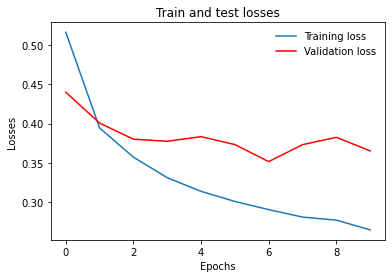

In [26]:
# importing the required module
import matplotlib.pyplot as plt
# x axis values
x = range(epochs)
# plotting the points 
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, test_losses, 'r', label = 'Validation loss')
  
plt.xlabel('Epochs')
plt.ylabel('Losses')
  
plt.title('Train and test losses')
plt.legend(frameon=False)# this is only to have the box for the legend or not

## Overfitting

By looking at the training and validation loss during the epochs, we can see the overfitting phenomenon.  
The network learns the training set better and better, but loosing the capacity to generalize and so it performs more and more poorly on the test set. But, the main goal of a model is to use it on new unseen data, so our goal is to decrease as much as possible the validation loss. Generally, the lowest validation loss is seen in the first epochs, so we have to do the so called *early stop* (*early stopping* methodology). Thus, we have to save the model at each epoch in order to use its best realization after having computed all the validation losses for all the epochs.  
  
Another well known methodology to avoid overfitting is named *dropout*, which randomply drop input units. This technique **forces the network to share information between the weights**, increasing its ability to generalize to new data.  
To use the dropout technique in PyTorch is easy thanks to the `nn.Dropout` module.  
Note: During the training we want to avoid overfitting thanks to the dropout, instead during the inference we want to use the entire network, indeed we have to switch off the dropout. To do this, we use `model.eval()` which sets the model to evaluation mode which sets the probability of droput to 0. We can turn on the dropout again by setting the model to train mode, thanks to `model.train()`.  
So, the general procedure is:  
1. Turn on the gradient computation together with the dropout mode, during the training phase  
2. Turn off the gradient computation together with the dropout, during the evaluation phase  
`
# turn off the gradients
with torch.no_grad():
    # set the model to evaluation mode
    model.val()

    # validation pass here
    for images, labels in testloader:
        # ...

    # set the model back to train phase
    model.train()
`

In [37]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [41]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

# we create 2 lists because we want to store the train and test
# losses for all the epochs
train_losses, test_losses = [], []

epochs = 30
for e in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        # for each batch of data we have to delete the previously
        # computed gradient
        optimizer.zero_grad()
        # we compute the log of probabilites
        log_ps = model(images)
        # we compute the running training error for a batch
        loss = criterion(log_ps, labels)
        # we add such trainig error for each batch
        # in order to compute the training error for a whole epoch
        running_loss += loss.item()
        # we do the backward
        loss.backward()
        # we update the parameters
        optimizer.step()
    else: # we have passed the data (we have done one epoch)
        # we switch off the autograd and the dropout, too
        with torch.no_grad():
            model.eval()
            test_loss = 0.0
            accuracy = 0.0
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()
                ps = torch.exp(log_ps)
                top_ps, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.float))
        # we have passed one epoch
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("{}/{} epochs ".format(e+1, epochs))
        print("Accuracy {:.3f}".format(accuracy/len(testloader)))
        print("Train Loss: {:.3f}".format(running_loss/len(trainloader)))
        print("Test Loss: {:.3f}".format(test_loss/len(testloader)))

1/30 epochs 
Accuracy 0.815
Train Loss: 0.604
Test Loss: 0.495
2/30 epochs 
Accuracy 0.845
Train Loss: 0.484
Test Loss: 0.426
3/30 epochs 
Accuracy 0.847
Train Loss: 0.452
Test Loss: 0.426
4/30 epochs 
Accuracy 0.850
Train Loss: 0.433
Test Loss: 0.408
5/30 epochs 
Accuracy 0.858
Train Loss: 0.426
Test Loss: 0.400
6/30 epochs 
Accuracy 0.856
Train Loss: 0.415
Test Loss: 0.416
7/30 epochs 
Accuracy 0.856
Train Loss: 0.403
Test Loss: 0.403
8/30 epochs 
Accuracy 0.858
Train Loss: 0.403
Test Loss: 0.400
9/30 epochs 
Accuracy 0.856
Train Loss: 0.393
Test Loss: 0.434
10/30 epochs 
Accuracy 0.867
Train Loss: 0.388
Test Loss: 0.379
11/30 epochs 
Accuracy 0.861
Train Loss: 0.386
Test Loss: 0.395
12/30 epochs 
Accuracy 0.860
Train Loss: 0.377
Test Loss: 0.388
13/30 epochs 
Accuracy 0.850
Train Loss: 0.380
Test Loss: 0.448
14/30 epochs 
Accuracy 0.865
Train Loss: 0.375
Test Loss: 0.398
15/30 epochs 
Accuracy 0.857
Train Loss: 0.379
Test Loss: 0.408
16/30 epochs 
Accuracy 0.866
Train Loss: 0.368
Te

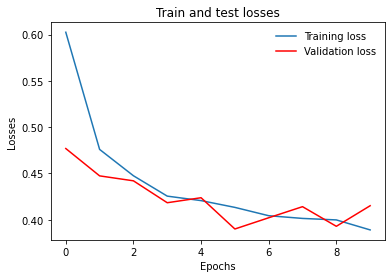

In [40]:
# importing the required module
import matplotlib.pyplot as plt
# x axis values
x = range(epochs)
# plotting the points 
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, test_losses, 'r', label = 'Validation loss')
  
plt.xlabel('Epochs')
plt.ylabel('Losses')
  
plt.title('Train and test losses')
plt.legend(frameon=False)# this is only to have the box for the legend or not

As it is possible to see the validation loss is much lower using the dropout.

## Inference
Now, the model is trained and so we can use it for inference. We have to remember to set the model again in evaluation case and to turn off the autograd function.
`model.eval()` and `torch.no_grad()`.

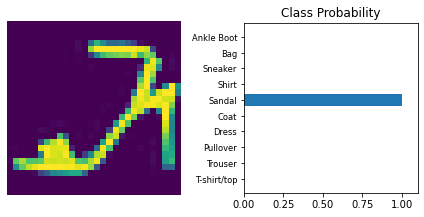

In [42]:
import helper

# Test the network
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

For the inference phase, we have used the model obtained in the last epoch, but, generally, we have to choose the model that performs best in the validation set. In our case, the minimum validation loss is in the 8-10 epoch. So, we want to save the trained models for each epoch in order to use the best performing model for inference purposes. Sometimes, we want to train a model more in a second time.